In [2]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# Load data

In [9]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]



PATH = "/groups/esm/dzhuang/Catheter/allparam/length/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 300
inputX_test_raw = np.load(INPUT_X)[:,0:n_data]
inputY_test_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_test_raw = np.load(INPUT_para)[:,0:n_data]
output_test_raw = np.load(OUTPUT)[:,0:n_data]

N_s, L_x = 2001, 500


# Visualize sampled data

Text(0, 0.5, 'L_p')

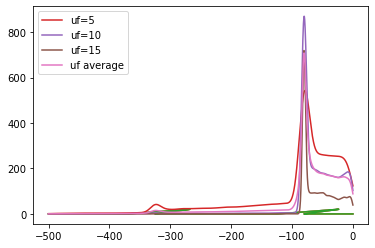

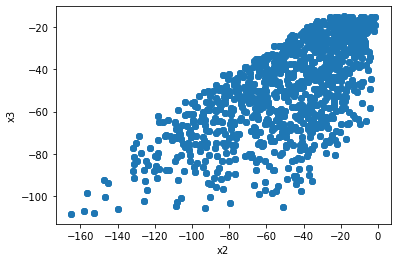

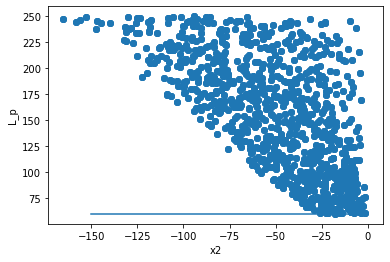

In [3]:

plt.figure()
test_id = 0
plt.plot(inputX_raw[:,3*test_id], inputY_raw[:,3*test_id])
plt.plot(inputX_raw[:,3*test_id+1], inputY_raw[:,3*test_id+1])
plt.plot(inputX_raw[:,3*test_id+2], inputY_raw[:,3*test_id+2])
sample, uf, L_p, x1, x2, x3, h = inputPara_raw[:,3*test_id]

xx = np.linspace(-L_x, 0, N_s)
plt.plot(xx, output_raw[:,3*test_id], label="uf=5")
plt.plot(xx, output_raw[:,3*test_id+1], label="uf=10")
plt.plot(xx, output_raw[:,3*test_id+2], label="uf=15")
plt.plot(xx, (output_raw[:,3*test_id]+output_raw[:,3*test_id+1]+output_raw[:,3*test_id+2])/3, label="uf average")
plt.legend()

plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel("x2")
plt.ylabel("x3")

plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.plot(np.linspace(-150,0,100), np.linspace(60,60,100))
plt.xlabel("x2")
plt.ylabel("L_p")


# Train Geo-FNO

Here we predicted the averaged bacteria distribution for three different flow rates.

In [6]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# zero tests 

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001
epochs = 1001
step_size = 100
gamma = 0.5


modes = 64
width = 64
s = N_s

################################################################
# preprocess training data
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output, dtype=torch.float).permute(1,0)
index = torch.randperm(ntrain)
train_index = index[:ntrain]
x_train = input[train_index]
y_train = output[train_index]
x_train = x_train.reshape(ntrain, s, 2)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True)                                 


################################################################
# preprocess test data
################################################################
inputX_test = inputX_test_raw[:, 0::3]
inputY_test = inputY_test_raw[:, 0::3]
inputPara_test = inputPara_test_raw[:, 0::3]
output_test = (output_test_raw[:, 0::3] + output_test_raw[:, 1::3] + output_test_raw[:, 2::3])/ 3.0
inputX_test = torch.tensor(inputX_test, dtype=torch.float).permute(1,0)
inputY_test = torch.tensor(inputY_test, dtype=torch.float).permute(1,0)
input_test = torch.stack([inputX_test, inputY_test], dim=-1)
output_test = torch.tensor(output_test, dtype=torch.float).permute(1,0)
x_test = input_test.reshape(ntest, s, 2)
y_test = output_test
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
                                          shuffle=False)

loss_data = np.zeros((3, epochs))

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    
    padding=100
    input_channel=2
    output_np=s

    model = FNO1d(modes, width, padding=padding, input_channel=input_channel, output_np=output_np).cuda()
    print(count_params(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = torch.exp(model(x))

            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()

        scheduler.step()

        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()
                out =  torch.exp(model(x))
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        train_l2 /= ntrain
        test_l2 /= ntest

        t2 = default_timer()
        print(ep, t2 - t1, train_l2, test_l2)
        
        loss_data[:, ep] = ep, train_l2, test_l2
        # save nn
        if ep%step_size==0:
            torch.save(model, 'catheter_plain_length_model_1d'+str(ep))


1336001
0 1.357914436608553 1.2290015068054199 0.6258391761779785
1 1.3392985751852393 0.6304887790679932 0.6014251804351807
2 1.3399244453758001 0.6104530344009399 0.5984669208526612
3 1.340198379009962 0.6002502059936523 0.5950922298431397
4 1.3411116255447268 0.5604231643676758 0.5636966800689698
5 1.3411270212382078 0.4979542989730835 0.48551124572753906
6 1.3384423796087503 0.45945981168746947 0.4871809768676758
7 1.3416814422234893 0.39206126403808594 0.37817627906799317
8 1.3403558945283294 0.36875978326797487 0.37830869674682616
9 1.3408918380737305 0.35519369411468504 0.34537649631500245
10 1.3440141109749675 0.35228342723846434 0.324619402885437
11 1.3406639834865928 0.34648139476776124 0.33146769523620606
12 1.340257616713643 0.2896002912521362 0.2830730628967285
13 1.3385896421968937 0.297656268119812 0.3590804481506348
14 1.3401115098968148 0.33156863403320314 0.28479331493377685
15 1.3621280072256923 0.2717291841506958 0.36110653400421144
16 1.3399088373407722 0.290346945

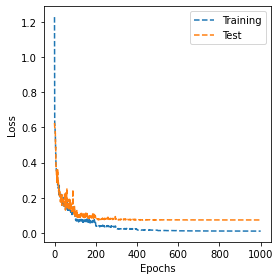

In [7]:
plt.figure(figsize=(4,4))
plt.plot(loss_data[0, :], loss_data[1, :], "--", label="Training")
plt.plot(loss_data[0, :], loss_data[2, :], "--", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("Loss.pdf")

# Verify the Geo-FNO model

rel. error is  0.054395
rel. error is  0.02668415


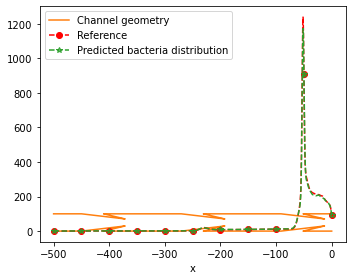

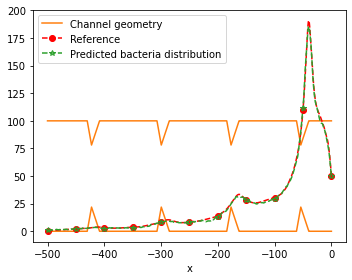

In [8]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"

n_data = 300
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]

N_s, L_x = 2001, 500


# PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
# INPUT_INFO = PATH+"data_info.npy"
# dataInfo = np.load(INPUT_INFO)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)


ntest = 100


modes = 64
width = 64
# nx ny
s = N_s

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output, dtype=torch.float).permute(1,0)

x_test = input.reshape(ntest, s, 2) 
y_test = output 


for sample_id in [0,8]:
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, sample_id]
    mesh = x_test[sample_id, :, :]
    
    y_test_pred = torch.exp(model(x_test[sample_id:sample_id+1,:,:].to(device))).detach().cpu().numpy().flatten()
    print("rel. error is ", np.linalg.norm(y_test_pred - y_test[sample_id, :].numpy())/np.linalg.norm(y_test[sample_id, :]))
    xx = np.linspace(-L_x, 0 ,N_s)
    plt.figure(figsize=(5,4))
    
    
    
    plt.plot(mesh[:, 0], mesh[:, 1], color="C1", label="Channel geometry")
    plt.plot(mesh[:, 0], 100-mesh[:, 1], color="C1")
    
    plt.plot(xx, y_test[sample_id, :], "--o", color="red", markevery=len(xx)//10, label="Reference")
    plt.plot(xx, y_test_pred, "--*", color="C2", fillstyle='none', markevery=len(xx)//10, label="Predicted bacteria distribution")

    plt.xlabel(r"x")
    
    plt.legend()
    plt.tight_layout()
    plt.savefig("Validation."+str(sample_id)+".pdf")
    